# **SPAM vs. naiwny klasyfikator Bayesa**

## Wprowadzenie
Nigeryjski książę wciąż zarabia na użytkownikach elektronicznych skrzynek pocztowych ponad 700 tys. dolarów rocznie ([źródło](https://www.cnbc.com/2019/04/18/nigerian-prince-scams-still-rake-in-over-700000-dollars-a-year.html))! Jak to możliwe?

Pierwsza przyczyna jest natury psychologicznej. Ofiary są poddawane "perfekcyjnej burzy pokuszeń", jak ujął to psycholog w wywiadzie, do którego linka dałam Wam powyżej. Spamerzy łączą granie na ludzkiej chciwości, ale także na pragnieniu bycia bohaterem. W końcu kto nie chciałby zarobić na byciu wspaniałomyślnym i szczodrym? W tej kwestii możemy pracować wyłącznie nad sobą.

Możemy za to pracować nad filtrami antyspamowymi. Użyjemy techniki, która nazywa się "worek ze słowami" (bag of words) w połączeniu z naiwnym klasyfikatorem Bayesa. Choć to prosty klasyfikator, z powodzeniem jest używany współcześnie (np. [SpamAssassin](https://cwiki.apache.org/confluence/display/spamassassin/BayesInSpamAssassin)).

Notebook oparty na tutorialach:
*   https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73
*   https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.model_selection import train_test_split

## Import danych treningowych
https://www.kaggle.com/uciml/sms-spam-collection-dataset

To dane przygotowane przez Almeida et al. na podstawie forum brytyjskiego, gdzie użytkownicy skarżą się na spamowe SMSy. Każdy wiersz składa się z kolumny opisującej czy wiadomość jest spamem, czy nie ('spam' czy 'ham'), a druga zawiera treść wiadomości.

In [2]:
url = "http://studenci.fuw.edu.pl/~akalinow/spam.csv"
df = pd.read_csv(url, encoding="latin-1")
print(df)

        v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  


Dane zawierają zbyteczne kolumny. 

**Proszę**:
* usunąć kolumny zawierające wartości "NaN"
* zmienić nazwy kolumn ```v1``` i ```v2``` na odpowiednio ```label```, oraz ```text```
* sprawdzić jakie wartości etykiet występują w danych - np. narysować histogram dla kolumny ```label```

**Wskazówka**: proszę użyć metod ```DataFrame.dropna()``` oraz ```DataFrame.rename()```

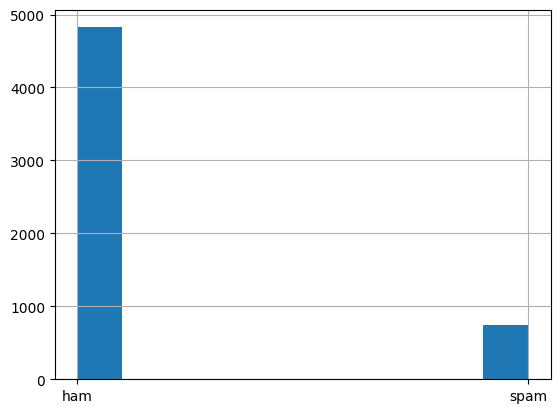

In [3]:
...
pass

**Proszę**: 

* wypisać na ekran treść komunikatu o indeksie 57

**Wskazówki**: 
* ogólnie `indeks` w DataFrame nie musi mieć postaci numeru wiersza. Dostęp przez numer wiersza uzyskujemy korzystając z ```DataFrame.iloc```
* w naszym przypadku indeks jest tożsamy z numerem wiersza, więc można użyć indeksu. Indeksy obiektu DataFrame uzyskujemy przez pole ```DataFrame.index```

In [4]:
...
pass

   label                                text
57   ham  Sorry, I'll call later in meeting.
label                                   ham
text     Sorry, I'll call later in meeting.
Name: 57, dtype: object


## Analiza częstości występowania słów w obu klasach za pomocą biblioteki WordCloud

WordCloud to biblioteka pozwalająca generować śliczne obrazki, na których wielkość słów odpowiada częstości jego występowania w danym zbiorze.

In [5]:
!pip3 install wordcloud
import wordcloud

/bin/pip3:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


Poniżej kod generujący obrazki dla spamu:

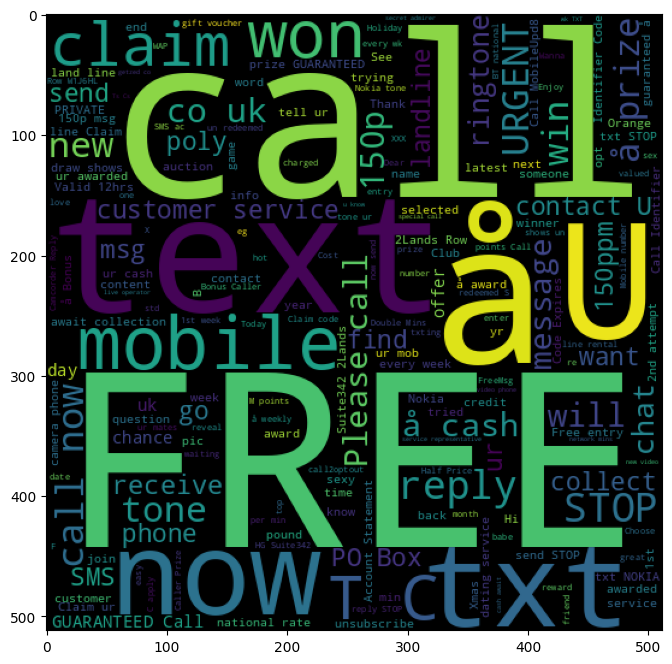

In [6]:
from wordcloud import WordCloud

spam_words = " ".join(list(df [df['label']=='spam']['text'] ))
spam_plot = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize=(10,8))
plt.imshow(spam_plot);

**Proszę**: 

* stworzyć analogiczny obrazek dla klasy ```ham```

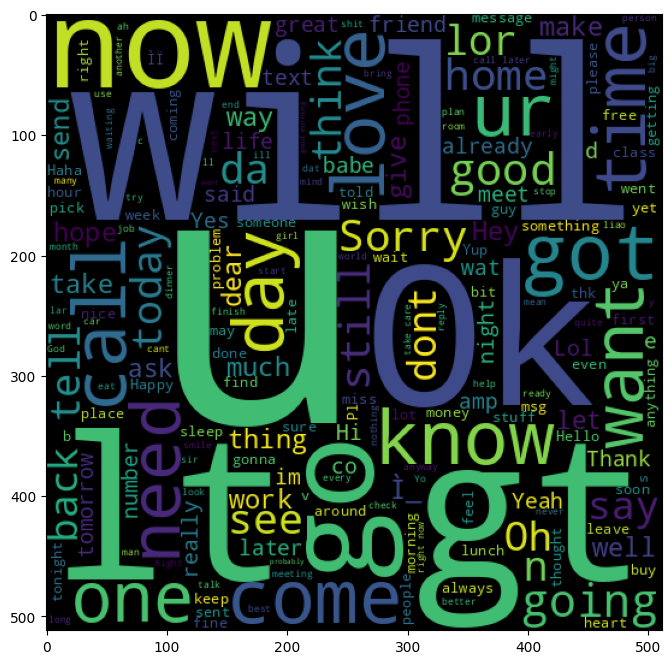

In [7]:
...
pass

Dane w tej chwili są w postaci ciągów słów. Potrzebujemy bardziej użytecznej **reprezentacji**. Wybór reprezentacji jest bardzo istotny dla modeli analizujących tekst. Komórka poniżej zamienia znajduje reprezentację tekstu przy użyciu algorytmu ```CountVectorizer```, który działa następująco:

1) utworzenie słownika, `vocabulary` w którym kluczem jest słowo, wartością częstość jego występowania w tekście.  Rozmiary liter i znaki przestankowe są ignorowane przy rozroznianiu słów
2) kodowanie ma postać macierzy o rzędzie dwa:
    * **wiersz** - zdanie z tekstu
    * **kolumny** - klucze słownika, tzn. numer kolumny odpowiada numerowi klucza. Liczba kolumn jest równa liczbie kluczy w całym tekście
    * **wartość** - zliczenia danego klucza w konkretnym zdaniu

**Uwaga:** w kontekście kodowania języka klucz jest często określany jako znacznik, `token`. np. 
[ChatGPT 3.5](https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them)
ma limit 4096 "tokenów" na cały tekst: pytania i odpowiedzi.  

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
text = ["Ala ala ma kota.", "Kot? Kot ma wszy."]
vectorizer = CountVectorizer()
vectorizer.fit(text)
print(colored("Original text:","blue"),text)
print(colored("Vocabulary:","blue"), vectorizer.vocabulary_)
print(colored("Lista słów:","blue"), vectorizer.get_feature_names_out())
text_transformed = vectorizer.transform(text)
print(colored("Transformed text:\n","blue"),text_transformed)
print(colored("Transformed text after decoding\n","blue"),vectorizer.inverse_transform(text_transformed))

Original text: ['Ala ala ma kota.', 'Kot? Kot ma wszy.']
Vocabulary: {'ala': 0, 'ma': 3, 'kota': 2, 'kot': 1, 'wszy': 4}
Lista słów: ['ala' 'kot' 'kota' 'ma' 'wszy']
Transformed text:
   (0, 0)	2
  (0, 2)	1
  (0, 3)	1
  (1, 1)	2
  (1, 3)	1
  (1, 4)	1
Transformed text after decoding
 [array(['ala', 'kota', 'ma'], dtype='<U4'), array(['kot', 'ma', 'wszy'], dtype='<U4')]


**Proszę**:

* przeprowadzić procedurę treningu reprezentacji i transformacji dla danych z e-maili.
* W dokumentacji CountVectorizer znajdź informację o parametrach max_df i min_df. Następnie spróbuj zastosować te parametry. Efekt tych parametrów można sprawdzać za pomocą metody ```vectorizer.stop_words_```.
* wypisać na ekran postać oryginalną i po transformacji maila o indeksie **57**.

In [9]:
...
pass

Original text:
 label                                   ham
text     Sorry, I'll call later in meeting.
Name: 57, dtype: object
Transformed text:
   (0, 1812)	1
  (0, 4520)	1
  (0, 4664)	1
  (0, 4954)	1
  (0, 7069)	1
Transformed text after decoding:
 [array(['call', 'later', 'll', 'meeting', 'sorry'], dtype='<U34')]
Terms that were ignored:
 {'you', 'and', 'in', 'my', 'for', 'to', 'me', 'the', 'it', 'your', 'is'}


## Trening klasyfikatora

**Proszę**:
* stworzyć kolumnę ```num_label``` w której ```spam``` będzie oznaczony jako **1**, a ```ham``` jako **0**
* podzielić dane na część treningową i testową w stosunku **7:3**
* wytrenować klasyfikator maili korzystając z naiwnego algorytmu Bayesa opartego o rozkład wielomianowy: ```MultinomialNB```
* wypisać na ekran udział poszczególnych klas w danych uczących: `f(MultinomialNB.class_log_prior_)`

Oczekiwany wynik (z dokładnością do fluktuacji statystycznych):
```Python
Class priors:
 [0.86820513 0.13179487]
```

In [10]:
...
pass

print(colored("Class priors:\n","blue"),np.exp(model.class_log_prior_))

Class priors:
 [0.86538462 0.13461538]


## Ocena jakości

**Proszę**: 

* oszacować jakość modelu wybierając samodzielnie metryki, które według Ciebie będą najlepiej sprawdzają czy model poprawnie rozdziela klasy
* odpowiedzieć na pytanie: **Jaki ułamek przypadków został poprawnie zaklasyfikowany?**
* odpowiedzieć na pytanie: **Jaki ułamek dobrych maili został błędnie zaklasyfikowany jako spam?**

Oczekiwany wynik (z dokładnością do fluktuacji statystycznych):
```Python
MCC: 0.92
ACC: 0.98
FPR: 0.01
```

MCC: 0.95
ACC: 0.99
FPR: 0.01
TPR: 0.95


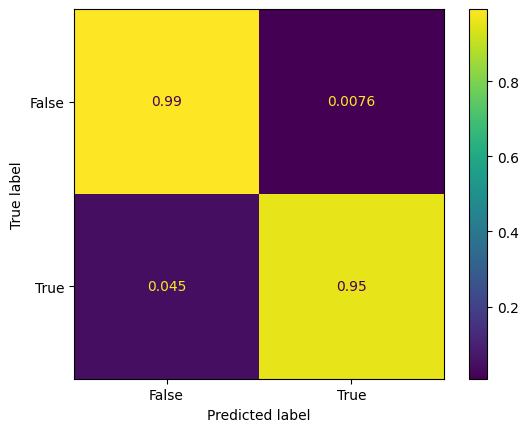

In [11]:
...

def printScores(model, X, Y):
...

printScores(model, X_test, Y_test);

## Analiza modelu

Sprawdźmy, czego właściwie maszyna się nauczyła. Analizując współczynniki modelu można wskazać słowa które są istotne dla klasyfikacji.

**Proszę**:

* wypisać na ekran informację o liczbie kluczy znalezionych w tekście przez ```CountVectorizer```
* wypisać na ekran kształt macierzy parametrów modelu ```MultinomialNB```: ```model.feature_log_prob_```
  i wyjaśnić dlaczego parametry modelu mają właśnie taki kształt
* obliczyć wystąpienia poszczególnych kluczy w obu kategoriach
* stworzyć listę zawierającą indeksy posortowanych współczynników: ```np.argsort(...)```
* wypisać na ekran po 10 słów o **największych** wartościach współczynników

**Wskazówki:** 

* by móc adresować listę słów inną listą, listę słów trzeba zamienić na macierz numpy.
* indeksy macierzy posortowanej według wartości w wierszach uzyskujemy przez 
```Python
imp = np.argsort(coeff, axis=0)
```
**Uwaga:** `argsort()` sortuje w porządku malejącym!

Oczekiwany wynik:
```Python
Liczba kluczy: (8661,)
Kształt macierzy parametrów modelu: (2, 8661)
Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii spam:
['call' 'free' 'or' 'now' 'txt' 'ur' 'on' 'have' 'from' 'stop']
Słowa, które które mają największe prawdopodobieństwo wystąpienia w kategorii ham:
['that' 'of' 'but' 'can' 'so' 'have' 'are' 'not' 'do' 'on']
```

In [12]:
N = 10

# Stwórz macierz numpy 'feature_names' ze słowami zapisanymi w module vectorizer:
...

# Stwórz macierz 'coeff' z prawdopodobieństwami odpowiadającymi słowom z macierzy 'feature_names':
...

# Znajdź indeksy N najważniejszych słów dla każdej z klas
...

print(colored("Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii spam:","blue"))
print(feature_names[imp_spam])

print(colored("Słowa, które które mają największe prawdopodobioeństwo wystąpienia w kategorii ham:","blue"))
print(feature_names[imp_ham])

Liczba kluczy: (8661,)
Kształt macierzy parametrów modelu: (2, 8661)
Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii spam:
['call' 'free' 'now' 'or' 'txt' 'on' 'ur' 'text' 'have' 'mobile']
Słowa, które które mają największe prawdopodobioeństwo wystąpienia w kategorii ham:
['that' 'of' 'have' 'so' 'can' 'on' 'but' 'not' 'are' 'do']


## Metody oszukiwania modelu

Gdybyście byli spamerami... Co moglibyście zrobić, znając tę technikę antyspamową?

* użycie znaków specjalnych w miejscu liter podobnych do tych znaków

**Proszę:**

* sprawdzić odpowiedź modelu na zdanie  `call for free`
* zmienić w tym zdaniu `a` na `@`
* sprawdzić ponownie odpowiedź modelu

In [13]:
...
pass

Is is spam? [ True]
Is is spam? [False]


**Proszę:**

* z całego zestawu danych, bez podziału na zbiory uczący i walidacyjny, wybrać te oznaczone jako `spam`
* zamienić litery `a` na znaki `@` w wybranych zdaniach
* obliczyć odpowiedź modelu 
* obliczyć ułamek zdań zaklasyfikowanych jako `ham`

**Wskazówka:**
* zamiany fragmentów napisów można dokonać z użyciem fukcji `np.char.replace()`
* tekst zawarty w DataFrame trzeba zamienić na macierz numpy, a następnie na typ napisowy:
  
  ```Python
  df.text.to_numpy().astype('str')
  ```

In [14]:
...
pass

Fraction of modified spam messages labeled as ham: 0.046


# Praca domowa

Przeprowadź analogiczną analizę dla zbioru tytułów [artykułów](https://www.kaggle.com/datasets/algord/fake-news?resource=download) 
posiadających informację o tym czy dany artykuł jest prawdziwy, `REAL`, czy fałszywy `FAKE`. 
Dane znajdują się tutaj: [link](http://studenci.fuw.edu.pl/~akalinow/FakeNewsNet.csv](http://studenci.fuw.edu.pl/~akalinow/FakeNewsNet.csv)

**Proszę**: 

* narysować `WordCloud` dla obu klas
* wytrenować ```CountVectorizer``` i przeprowadzić transformację tekstu do postaci numerycznej
* wytrenować klasyfikator ```MultinomialNB``` z podziałem na zbiory uczący i walidacyjny
* wypisać metryki dla modelu
* znaleźć 10 słów najczęściej występujących w tekstach obu kategorii
* odpowiedzieć na pytanie:  **Jaki ułamek fałszywych artykułów został oznaczony jako prawdziwe?**

In [15]:
# Wczytywanie danych
...
df.head()

,text,label
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1


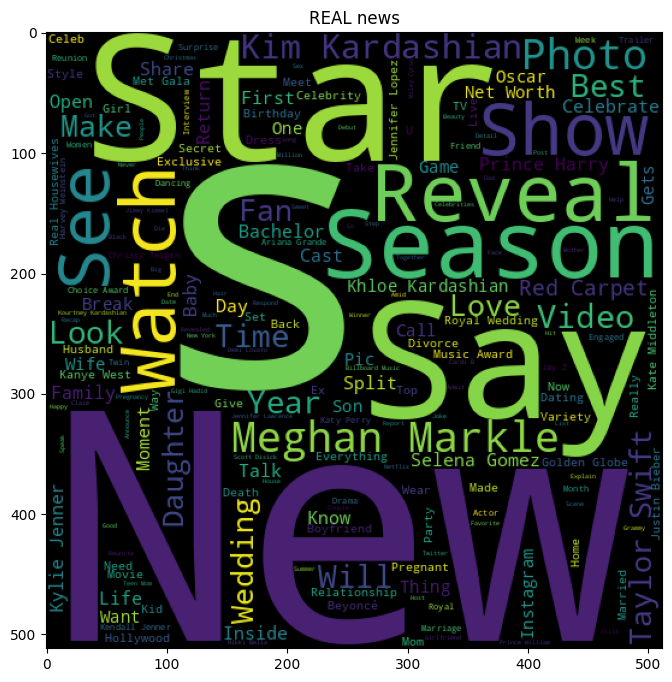

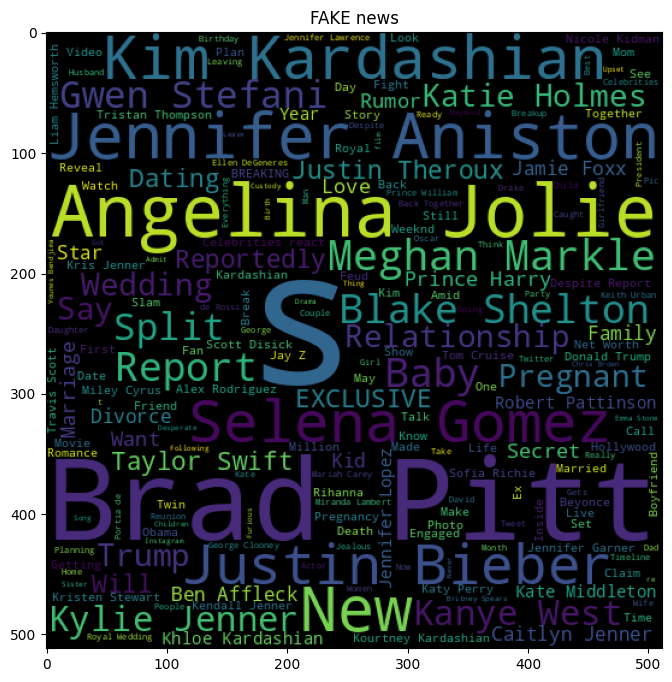

In [16]:
#WordCloud dla obu klas
...
pass

MCC: 0.51
ACC: 0.82
FPR: 0.39
TPR: 0.89
39.15% fałszywych informacji oznaczono jako prawdziwe.


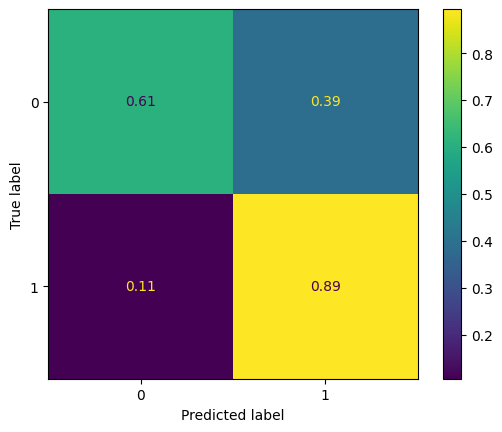

In [17]:
# trening
...
pass

print("{:.2f}%".format((fpr)*100), colored("fałszywych informacji oznaczono jako prawdziwe.", "blue"))

In [18]:
#10 najbardziej istotnych słów dla obu klas
...
pass

Słowa, które mają największe prawdopodobieństwo wystąpienia w kategorii REAL:
['the' 'and' 'to' 'of' 'in' 'on' 'with' 'her' 'for' 'is']
Słowa, które które mają największe prawdopodobioeństwo wystąpienia w kategorii FAKE:
['to' 'and' 'the' 'with' 'is' 'of' 'in' 'on' 'for' 'jennifer']
